# GipsyX parsers

Examples are shown how to use some of following Midgard Gipsy/GipsyX parsers:

| Parser name        | Description                        |
| :------------------| :--------------------------------- |
| gipsy_stacov       | Gipsy station covariance file |
| gipsy_sum          | Gipsy summary file | 
| gipsy_tdp          | Gipsy time dependent parameter file |
| gipsyx_gdcov       | GipsyX estimates and covariance information file |
| gipsyx_residual    | GipsyX residual file |
| gipsyx_series      | GipsyX timeseries file |
| gipsyx_tdp         | GipsyX time dependent parameter file |
| gipsyx_summary     | GipsyX summary file |

## Use of gipsyx_residual parser

An example is shown, how to use the **gipsyx_residual** parser:

In [2]:
# Import parsers package
from midgard import parsers

# Import unit package for unit conversion
from midgard.math.unit import Unit

# Read file by generating an instance of a Parser class
p = parsers.parse_file(parser_name="gipsyx_residual", file_path="../../tests/parsers/example_files/gipsyx_residual")

# Generate dataset based on read file data
dset = p.as_dataset()

**dset** is a Midgard dataset with following data fields, which represents a column in the dataset:

| Field               | Type              | Description                                                        |
| :------------------ | :---------------- | :----------------------------------------------------------------- |
| azimuth             | numpy.ndarray     | Azimuth from receiver                                              |
| azimuth_sat         | numpy.ndarray     | Azimuth from satellite                                             |
| data_type           | numpy.ndarray     | Data type (e.g. IonoFreeC_1P_2P, IonoFreeL_1P_2P)                  |
| deleted             | numpy.ndarray     | Boolean array which indicates deleted residuals (True = deleted)   |
| elevation           | numpy.ndarray     | Elevation from receiver                                            |
| elevation_sat       | numpy.ndarray     | Elevation from satellite                                           |
| residual            | numpy.ndarray     | Post-fit residual                                                  |
| satellite           | numpy.ndarray     | Satellite PRN number together with GNSS identifier (e.g. G07)      |
| station             | numpy.ndarray     | Station name list                                                  |
| system              | numpy.ndarray     | GNSS identifier (e.g. G or E)                                      |
| time                | Time              | Parameter time given as TimeTable object                           |

In [10]:
# Show dataset fields
dset.fields

['azimuth',
 'azimuth_sat',
 'data_type',
 'deleted',
 'elevation',
 'elevation_sat',
 'residual',
 'satellite',
 'station',
 'system',
 'time']

The **site_pos** dataset field includes the station coordinates read from the Bernese CRD file. The **site_pos** field is an **Position** object with methods for conversion from geocentric coordinates (X, Y, Z) to geodetic coordinates (latitude, longitude, height) given in **radian** (see **position.ipynb** Jupyter notebook for more information).

In [ ]:
for sta, lat, lon in zip(dset.station, dset.site_pos.llh.lat, dset.site_pos.llh.lon):
    print(f"{sta.upper()}  LAT {lat*Unit.rad2deg:.4f} deg, LON {lon*Unit.rad2deg:.4f} deg")

In the following it is shown how to plot the station coordinates with **matplotlib** and **cartopy**:

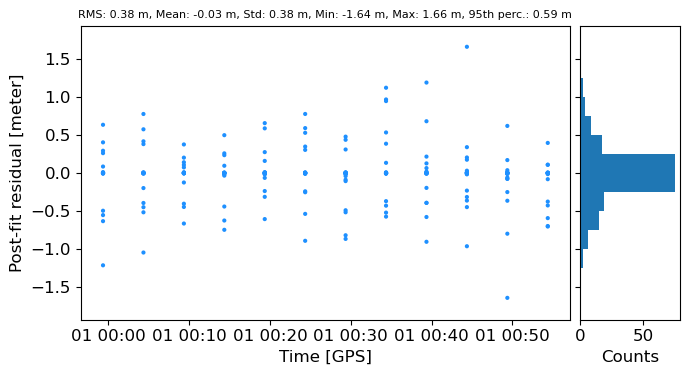

In [10]:
# Do not show Python warnings
import warnings
warnings.filterwarnings("ignore")

# Import MatPlotExt class - a wrapper around matplotlib
from midgard.plot.matplotext import MatPlotExt

# Get instance of MatPlotExt class
plt = MatPlotExt()

# Plot residuals together with histogram and statistical title line
plt.plot(
    x_arrays=dset.time.gps.datetime,
    y_arrays=dset.residual,
    xlabel="Time [GPS]",
    ylabel="Post-fit residual",
    y_unit="meter",
    colors=["dodgerblue"],
    options={
        "figsize": (7, 4),
        "histogram": "y",
        "histogram_size": 1.0,
        "plot_to": "console",
        "statistic": ["rms", "mean", "std", "min", "max", "percentile"],
    },
)

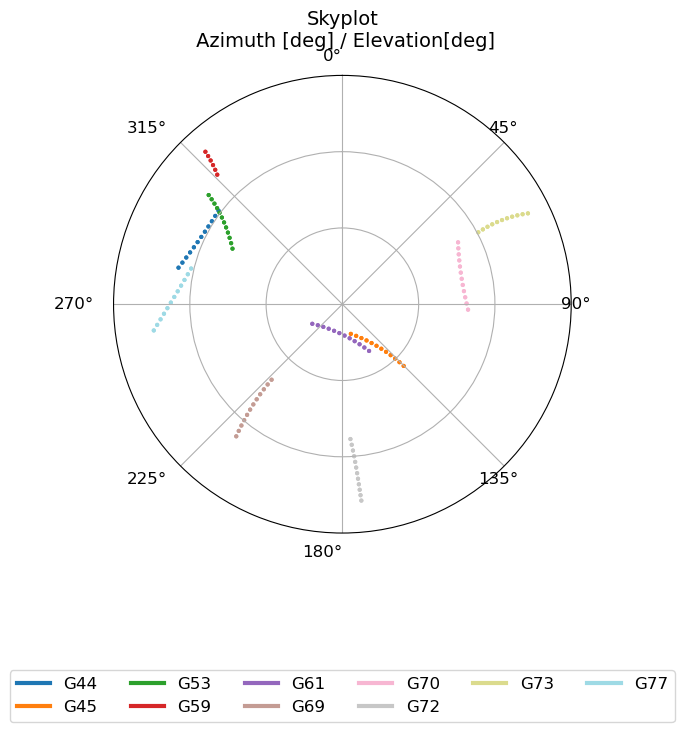

In [11]:
# Third party imports
import numpy as np

# Import MatPlotExt class - a wrapper around matplotlib
from midgard.plot.matplotext import MatPlotExt

# Get instance of MatPlotExt class
plt = MatPlotExt()

# Generate x- and y-axis data per satellite
x_arrays = []
y_arrays = []
labels = []
for sat in sorted(dset.unique("satellite")):
    
    if sat == "None":
        continue
        
    # Get only data for given satellite by using indices
    idx = dset.filter(satellite=sat)
    
    x_arrays.append(np.deg2rad(dset.azimuth[idx]))
    y_arrays.append(90.0 - dset.elevation[idx])
    labels.append(sat)

# Plot with polar projection
plt = MatPlotExt()
plt.plot(
    x_arrays=x_arrays,
    y_arrays=y_arrays,
    xlabel="",
    ylabel="",
    y_unit="",
    labels=labels,
    options={
        "colormap": "tab20",
        "figsize": (7, 7.5),
        "legend": True,
        "legend_ncol": 6,
        "legend_location": "bottom",
        "plot_to": "console",
        "plot_type": "scatter",
        "projection": "polar",
        "title": "Skyplot\n Azimuth [deg] / Elevation[deg]",
        "xlim": [0, 2 * np.pi],
        "ylim": [0, 90],
        "yticks": (range(0, 90, 30)),  # sets 3 concentric circles
        "yticklabels": (map(str, range(90, 0, -30))),  # reverse labels from zenith distance to elevation
    },
)

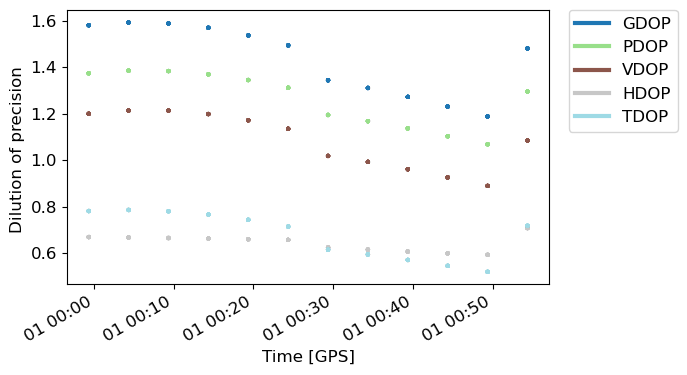

In [12]:
# Third party imports
import numpy as np

# Import MatPlotExt class - a wrapper around matplotlib
from midgard.plot.matplotext import MatPlotExt

from midgard.gnss import compute_dops

# Dataset can include other satellite related parameter information (e.g. from TDP file). Therefore NaN values has
# to be removed.
num_obs = dset.num_obs
epochs = dset.time.gps.datetime

# Initialize empty dilution of precision (DOP) arrays
dops = {
    "gdop": np.zeros((num_obs)),
    "pdop": np.zeros((num_obs)),
    "tdop": np.zeros((num_obs)),
    "hdop": np.zeros((num_obs)),
    "vdop": np.zeros((num_obs)),
}

# Determine DOP values
for epoch in set(epochs):
    idx = epoch == epochs
    (
        dops["gdop"][idx],
        dops["pdop"][idx],
        dops["tdop"][idx],
        dops["hdop"][idx],
        dops["vdop"][idx],
    ) = compute_dops.compute_dops(np.deg2rad(dset.azimuth[idx]), np.deg2rad(dset.elevation[idx]))



# Get instance of MatPlotExt class
plt = MatPlotExt()

# Generate x- and y-axis data per satellite
x_arrays = []
y_arrays = []
labels = []
for sat in sorted(dset.unique("satellite")):
    
    if sat == "None":
        continue
        
    # Get only data for given satellite by using indices
    idx = dset.filter(satellite=sat)
    
    x_arrays.append(np.deg2rad(dset.azimuth[idx]))
    y_arrays.append(90.0 - dset.elevation[idx])
    labels.append(sat)

# Plot DOPs
plt = MatPlotExt()
plt.plot(
    x_arrays=[epochs, epochs, epochs, epochs, epochs],
    y_arrays=[dops["gdop"], dops["pdop"], dops["vdop"], dops["hdop"], dops["tdop"]],
    xlabel="Time [GPS]",
    ylabel="Dilution of precision",
    y_unit="",
    labels=["GDOP", "PDOP", "VDOP", "HDOP", "TDOP"],
    options={
        "figsize": (7, 4), 
        "legend": True, 
        "plot_to": "console",
    },
)

## Use of gipsyx_tdp parser

An example is shown, how to use the **gipsyx_tdp** parser:

In [ ]:
# Import parsers package
from midgard import parsers

# Import unit package for unit conversion
from midgard.math.unit import Unit

# Read file by generating an instance of a Parser class
p = parsers.parse_file(parser_name="gipsyx_tdp", file_path="../../tests/parsers/example_files/gipsyx_tdp")

# Generate dataset based on read file data
dset = p.as_dataset()

**dset** is a Midgard dataset, which can include following data fields:

| Field                | Type              | Description                                                       |
| :------------------- | :---------------- | :---------------------------------------------------------------- |
| receiver_clock       | numpy.ndarray     | Receiver clock parameter                                          |
| satellite            | numpy.ndarray     | Satellite SVN number together with GNSS identifier (e.g. G62)     |
| satellite_clock      | numpy.ndarray     | Satellite clock parameter                                         |
| satellite_ant_pco    | PositionTable     | Satellite antenna phase center offset                             |
| site_posvel          | PosVel            | Station coordinates and velocities                                |
| source_id            | numpy.ndarray     | Source ID                                                         |
| station              | numpy.ndarray     | Station name list                                                 |
| system               | numpy.ndarray     | GNSS identifier (e.g. G or E)                                     |
| time                 | Time              | Parameter time given as TimeTable object                          |
| trop_zenith_model    | numpy.ndarray     | Zenith hydrostatic/dry troposphere delay parameter                |
| trop_zenith_wet      | numpy.ndarray     | Zenith wet troposphere delay parameter                            |
| trop_gradient_east   | numpy.ndarray     | Troposphere horizontal delay gradient in the East direction       |
| trop_gradient_north  | numpy.ndarray     | Troposphere horizontal delay gradient in the North direction      |

The fields above are given for 'apriori', 'value' and 'sigma' Dataset collections.